# *Model* spatial data

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.model import spreg
from pysal.model.mgwr.gwr import GWR
from pysal.model.mgwr.sel_bw import Sel_BW

db = gpd.read_file('../data/demo_data.gpkg')
w = weights.Queen.from_dataframe(db)
w.transform = 'R'

/opt/conda/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Non-spatial regression (OLS)

$$
y_i = X_i \beta + \epsilon_i
$$

In [2]:
y = 'arturo_score'
x = ['land_use_mix', 'closeness_small_parks', 
     'residence_ratio', 'age_diversity']

ols = spreg.OLS(db[[y]].values,
                db[x].values,
                w=w,
                name_y=y,
                name_x=x,
                spat_diag=True)

ols

In [3]:
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :arturo_score                Number of Observations:         128
Mean dependent var  :     24.8409                Number of Variables   :           5
S.D. dependent var  :      2.4354                Degrees of Freedom    :         123
R-squared           :      0.3087
Adjusted R-squared  :      0.2862
Sum squared residual:     520.758                F-statistic           :     13.7286
Sigma-square        :       4.234                Prob(F-statistic)     :   2.766e-09
S.E. of regression  :       2.058                Log likelihood        :    -271.432
Sigma-square ML     :       4.068                Akaike info criterion :     552.865
S.E of regression ML:      2.0170                Schwarz criterion     :     567.125

-----------------------------------------------------------------------------

## Spatial Lag

$$
y_i = \sum_j w_{ij} y_j + X_i \beta + \epsilon_i
$$

In [4]:
slm = spreg.ML_Lag(db[[y]].values,
                   db[x].values,
                   w=w,
                   name_y=y,
                   name_x=x)

print(slm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :arturo_score                Number of Observations:         128
Mean dependent var  :     24.8409                Number of Variables   :           6
S.D. dependent var  :      2.4354                Degrees of Freedom    :         122
Pseudo R-squared    :      0.4608
Spatial Pseudo R-squared:  0.3602
Sigma-square ML     :       3.193                Log likelihood        :    -259.557
S.E of regression   :       1.787                Akaike info criterion :     531.114
                                                 Schwarz criterion     :     548.226

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/opt/conda/lib/python3.6/site-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


## Spatial regimes

$$
y_i = X_i \beta_r + \epsilon_i
$$

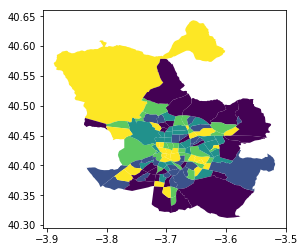

In [5]:
db.assign(resid=ols.u)\
  .plot(column='resid', scheme='quantiles')

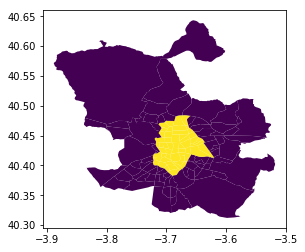

In [6]:
centro = ['Tetuán', 'Chamartín', 'Ciudad Lineal',
          'Salamanca', 'Chamberí', 'Centro', 'Arganzuela',
          'Retiro']
db['centro'] = 0
db.loc[db['neighbourhood_group'].isin(centro), 'centro'] = 1

db.plot('centro');

In [7]:
ols_r = spreg.OLS_Regimes(db[[y]].values,
                          db[x].values,
                          db['centro'].values,
                          w=w,
                          name_y=y,
                          name_x=x)

print(ols_r.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :0_arturo_score                Number of Observations:          76
Mean dependent var  :     23.8474                Number of Variables   :           5
S.D. dependent var  :      2.0900                Degrees of Freedom    :          71
R-squared           :      0.2446
Adjusted R-squared  :      0.2020
Sum squared residual:     247.464                F-statistic           :      5.7476
Sigma-square        :       3.485                Prob(F-statistic)     :   0.0004584
S.E. of regression  :       1.867                Log likelihood        :    -152.699
Sigma-square ML     :       3.256                Akaike info criterion :     315.399
S.E of regression ML:      1.8045                Schwarz criterion     :     327.053

------------------------------

## Geographically Weighted Regression

$$
y_i = X_i \beta_i + \epsilon_i
$$

* Set up

In [8]:
ptX = db.centroid.x
ptY = db.centroid.y
coords = pd.DataFrame({'X': ptX,
                       'Y': ptY}).values

* Bandwith selection

In [9]:
selector = Sel_BW(coords, 
                  db[[y]].values,
                  db[x].values)
bw = selector.search()

* Fit

In [10]:
gwr = GWR(coords,
          db[[y]].values,
          db[x].values,
          bw)\
      .fit()

* Visualise results for the intercept

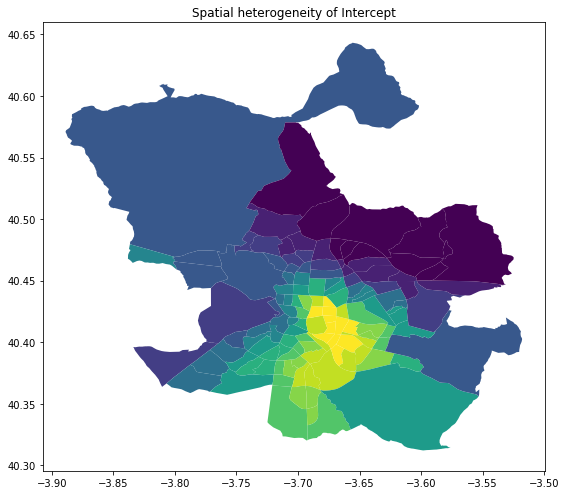

In [11]:
ax = db.assign(c=gwr.params[:, 0])\
       .plot('c', scheme='quantiles', k=12,
             figsize=(9, 9))
ax.set_title('Spatial heterogeneity of Intercept');